In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchvision.datasets import Cityscapes
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import segmentation_models_pytorch as smp
from PIL import Image

# plt.rcParams['figure.figsize'] = (5, 5)
# plt.rcParams['figure.facecolor'] = 'gray'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [3]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colors = dict(zip(range(n_classes), colors))
label_colors

{0: [0, 0, 0],
 1: [128, 64, 128],
 2: [244, 35, 232],
 3: [70, 70, 70],
 4: [102, 102, 156],
 5: [190, 153, 153],
 6: [153, 153, 153],
 7: [250, 170, 30],
 8: [220, 220, 0],
 9: [107, 142, 35],
 10: [152, 251, 152],
 11: [0, 130, 180],
 12: [220, 20, 60],
 13: [255, 0, 0],
 14: [0, 0, 142],
 15: [0, 0, 70],
 16: [0, 60, 100],
 17: [0, 80, 100],
 18: [0, 0, 230],
 19: [119, 11, 32]}

In [4]:
class CustomCityscapes(Cityscapes):
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        target = Image.open(self.targets[idx][0])
        t = transforms.ToTensor()
        return t(image), transforms.PILToTensor()(target)[0]

In [5]:
train_ds = CustomCityscapes(root="./cityscapes_small/",
                      split="train", mode="fine", target_type='semantic')
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True, generator=torch.random.manual_seed(0),
                      num_workers=os.cpu_count())
val_ds = CustomCityscapes(root="./cityscapes_small/",
                    split="val", mode="fine", target_type='semantic')
val_dl = DataLoader(val_ds, batch_size=10, num_workers=os.cpu_count())


In [6]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.detach().numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colors[l][0]
        g[temp == l] = label_colors[l][1]
        b[temp == l] = label_colors[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

def visualize(p, m, predicted, save=False):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_axis_off()
    ax.imshow(p)
    ax = fig.add_subplot(1, 3, 2)
    ax.set_axis_off()
    ax.imshow(decode_segmap(encode_segmap(m)))
    ax = fig.add_subplot(1, 3, 3)
    ax.set_axis_off()
    ax.imshow(decode_segmap(predicted))
    if save:
        fig.savefig("out.png")


class LearningModel(pl.LightningModule):
    def __init__(self, ):
        super().__init__()
        self.unet = smp.Unet(classes=len(colors))
        self.criterion = smp.losses.DiceLoss(mode="multiclass")
        self.iou = torchmetrics.JaccardIndex(num_classes=n_classes)
        self.accuracy = torchmetrics.Accuracy(num_classes=n_classes, multiclass=True)
    
    def forward(self, x):
        segments = self.unet(x)
        return segments

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y = encode_segmap(y)
        y_hat = self.unet(x)
        loss = self.criterion(y_hat, y.long())
        iou = self.iou(y_hat, y)
        # acc = self.accuracy(torch.argmax(y_hat,axis=1), y)
        self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        # self.log('train_acc', acc,on_step=False, on_epoch=True,prog_bar=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y = encode_segmap(y)
        y_hat = self.unet(x)
        loss = self.criterion(y_hat, y.long())
        iou = self.iou(y_hat, y)
        # acc = self.accuracy(torch.argmax(y_hat,axis=1), y)
        self.log('val_loss', loss)
        self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        # self.log('val_acc', acc,on_step=False, on_epoch=True,prog_bar=False)
        return loss


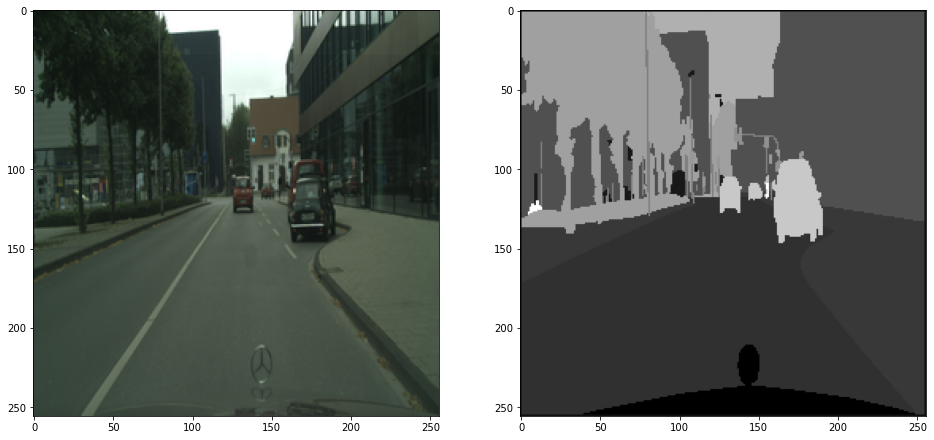

In [7]:
img,seg= val_ds[20]
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [8]:
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  3,  4,  5,  7,  8, 11, 17, 19, 20, 21, 22, 23, 25, 26, 33],
       dtype=torch.uint8)
16


In [9]:
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))


torch.Size([256, 256])
tensor([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11, 13, 14, 19], dtype=torch.uint8)
13


In [10]:
res1=decode_segmap(res.clone())
res1.shape

(256, 256, 3)

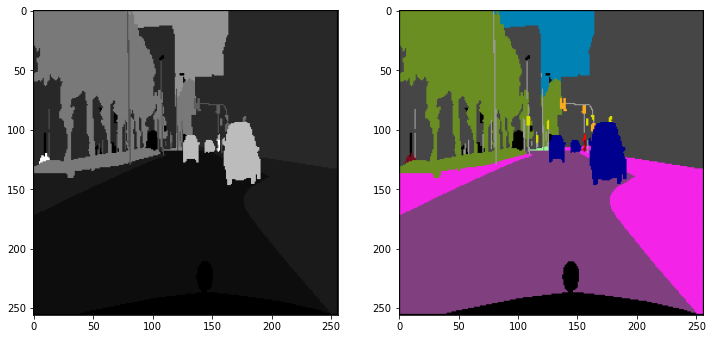

In [11]:

fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

In [12]:
model = LearningModel.load_from_checkpoint("./lightning_logs/version_12/checkpoints/cityscapes-small-dataset-unet-epoch=39-train_loss=0.29.ckpt")
# model = LearningModel()
# checkpoint_callback = ModelCheckpoint(
#     save_top_k=10,
#     monitor="train_loss",
#     mode="min",
#     filename="cityscapes-small-dataset-unet-{epoch:02d}-{train_loss:.2f}",
#     every_n_epochs=10
# )
# trainer = pl.Trainer(max_epochs=200, accelerator="gpu", gpus=1, log_every_n_steps=10,
#                      callbacks=[checkpoint_callback])
# trainer.fit(model, train_dl, val_dl, ckpt_path="./lightning_logs/version_11/checkpoints/cityscapes-small-dataset-unet-epoch=19-train_loss=0.34.ckpt")


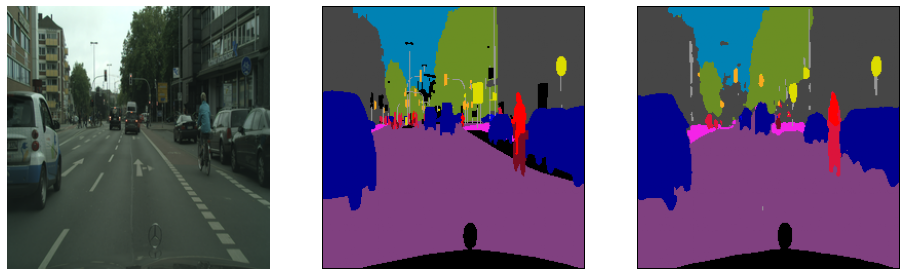

In [25]:
idx = 9
p, l = val_ds[idx]
y_hat = model(p.reshape((1,p.shape[0],p.shape[1],p.shape[2])))

visualize(p.permute(1,2,0), l, torch.argmax(y_hat[0],axis=0), save=False)